In [6]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.signal import lfilter
from scipy.optimize import curve_fit

In [166]:
#----------
path = r'C:\Users\FChabot\Documents\Tomography\Compression\0p65mm_Mott_N115' #Path of the folder containing the folder "1- Analysis" where csv files where saved
inputFileName = '0p65mm_Mott_N115_Dry'  #Name of the first part of the csv files saved in the folder "1-Analysis"
outputFileName = inputFileName           #Name of the output file
#----------

outputFolder = '1- Analysis'
outputPath = os.path.join(path, outputFolder)
def func (x, a, b, c, d): #Function used to fit the position of the porous layers edges
    return a*x**3+b*x**2+c*x+d

C:\Users\FChabot\Documents\Tomography\Compression\0p65mm_Mott_N115\1- Analysis\0p65mm_Mott_N115_Dry_GDL_last.csv
C:\Users\FChabot\Documents\Tomography\Compression\0p65mm_Mott_N115\1- Analysis\0p65mm_Mott_N115_Dry_GDL_first.csv
C:\Users\FChabot\Documents\Tomography\Compression\0p65mm_Mott_N115\1- Analysis\0p65mm_Mott_N115_Dry_PTL_last.csv
C:\Users\FChabot\Documents\Tomography\Compression\0p65mm_Mott_N115\1- Analysis\0p65mm_Mott_N115_Dry_PTL_first.csv


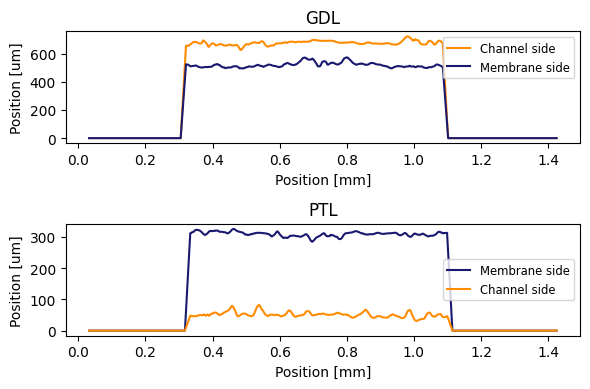

In [167]:
#Smooth curve and average over slices
#Comment: data = 0 where image was cropped
#---------------
min_slices, max_slices = [0, 360] #Index range of slices to use
c = ['darkorange', 'midnightblue']
pixSize = 0.635 #um

#Parameter to remove outliers, function lfilter from scipy.signal
n = 25  # the larger n is, the smoother will be the resulting curve
b = [1.0 / n] * n
a = 1
#------------

files = [ '_GDL_last.csv', '_GDL_first.csv','_PTL_last.csv', '_PTL_first.csv', ]
label = ['Channel side', 'Membrane side', 'Membrane side', 'Channel side']
path = outputPath
c = c + list(reversed(c))
fig, ax = plt.subplots(2,1, figsize=(6, 4))
filt_Data = []
r = 0
fg = 0
for suffix in files:
    if r>1:
        fg = 1
    dataPath = os.path.join(path, inputFileName + suffix)
    print(dataPath)
    df = pd.read_csv(dataPath)

    y = np.zeros(len(df.iloc[0]), np.float64)
    for ind in df.index[min_slices: max_slices]:
        y += lfilter(b, a, df.iloc[ind])
    y = y/len(df.index[min_slices: max_slices])
    filt_Data.append(y)
    y_mm = y
    x_mm = np.linspace(0, len(y), len(y))
    ax[fg].plot(np.array(x_mm[50:-50])*pixSize/1000, np.array(y_mm[50:-50])*pixSize, c=c[r], label=label[r])
    r += 1
    
ax[0].set_title('GDL')
ax[0].set_xlabel('Position [mm]')
ax[0].set_ylabel('Position [um]')
ax[0].legend(loc=1, fontsize='small')
ax[1].set_title('PTL') 
ax[1].set_xlabel('Position [mm]')
ax[1].set_ylabel('Position [um]')
ax[1].legend(loc=7, fontsize='small')
fig.tight_layout()

d = {'GDL - Channel':filt_Data[0],
     'GDL - Membrane':filt_Data[1],
     'PTL - Membrane':filt_Data[2],
     'PTL - Channel':filt_Data[3],}

df_filt = pd.DataFrame(d)
df_filt.to_csv(os.path.join(path, outputFileName + '_filtered-data.csv'), index=False)

Middle pixel value: 1107
Channel:
- minimum pixel: 608
- maximum pixel: 1599


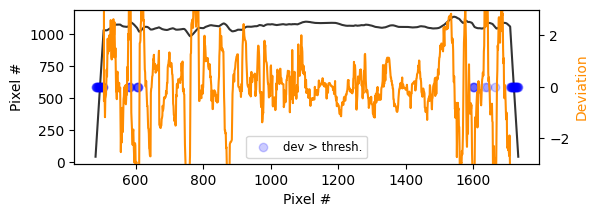

In [243]:
# Detection of the channel boundaries (cathode side)
# Channel edges are determined considering that the channel is roughly at centered in the image 
# Comment: if not working, enter the position manually at the bottom of this cell
#-------
dev_thresh = 4.1 #Threshold value to determine channel edges
#-------

df = pd.read_csv(os.path.join(path, outputFileName + '_filtered-data.csv'))
y = df['GDL - Channel']#[lim: -lim] #Column can be replaced by 'PTL - Channel'
y = y[y>1]
x = y.index
dev_y = np.array(y[1:])-np.array(y[:-1])
middle = round((ind[-1]-ind[0])/2+ind[0])
print('Middle pixel value:', middle)

#Calculate the deviation of the position
r=0
ind = []
for dev in dev_y:
    if abs(dev) > dev_thresh:
        ind += [x[r]]
    r +=1
ind_y = np.zeros(len(ind))

fig, ax1 = plt.subplots(figsize=(6, 2))
ax2 = ax1.twinx()
ax2.scatter(ind, ind_y, color='blue', marker='o', alpha=0.2, label='dev > thresh.') #Pixels disregarded for the next cells
ax2.plot(x[1:], dev_y, c='darkorange')
ax1.plot(x, y, c='k', alpha=0.8)
ax1.set_ylabel('Pixel #')
ax1.set_xlabel('Pixel #')
ax2.set_ylabel('Deviation', color='darkorange')
ax2.set_ylim(-3,3)
# ax2.set_ylim(bottom=-5, top=5)
ax2.legend(fontsize='small')
            
#Parameters lim_low and lim_high will be used in the following cells to plot results in the channe only
i=0
while ind[i]<middle:
    lim_low = ind[i]
    i+=1
lim_high = ind[i]

#---------
# lim_low, lim_high = 436, 2028  #Manual input
#---------

print('Channel:')
print('- minimum pixel:', lim_low)
print('- maximum pixel:', lim_high)

0 : GDL - Channel
1 : GDL - Membrane
2 : PTL - Membrane
3 : PTL - Channel


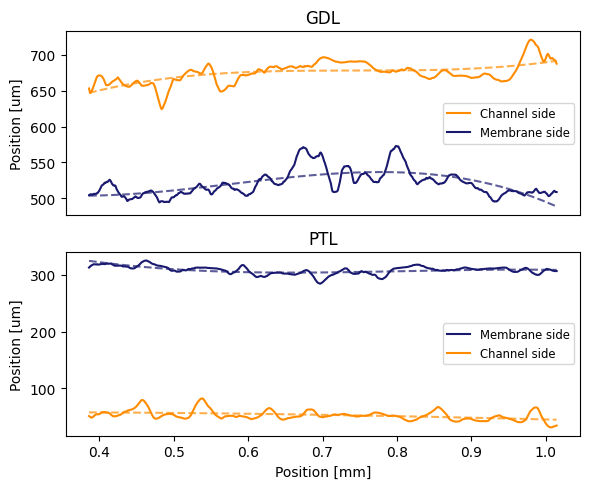

In [244]:
#Plot withing the channel location of the filtered data and of the fit
fig, ax = plt.subplots(2,1, figsize=(6, 5))
popt_list = []
r = 0
fg = 0
for pos in df.columns[:]:
    if r>1:
        fg = 1
    print(r, ':', pos)
    # print(df[pos].iloc[0], df[pos].iloc[-1])
    y = df[pos].iloc[lim_low:lim_high]
    x = y.index[:]
    ax[fg].plot(np.array(x)*pixSize/1000, np.array(y)*pixSize, c=c[r], label=label[r])

    popt, pcov = curve_fit(func, x , y)
    fit = func(x, *popt)
    ax[fg].plot(np.array(x)*pixSize/1000, np.array(fit)*0.635, c=c[r], linestyle='--', alpha=0.7)
    r += 1
    popt_list.append(popt)

d = {df.columns[0]:[lim_low, lim_high]+list(popt_list[0]),
     df.columns[1]:[lim_low, lim_high]+list(popt_list[1]),
     df.columns[2]:[lim_low, lim_high]+list(popt_list[2]),
     df.columns[3]:[lim_low, lim_high]+list(popt_list[3])}

data = pd.DataFrame(d, index=['pix min', 'pix max', 'a', 'b', 'c', 'd'])
data.to_csv(os.path.join(path, outputFileName + '_Fit.csv'))
    
ax[0].set_title('GDL')
# ax[0].set_xlabel('Position [mm]')
ax[0].set_xticks([])
ax[0].set_ylabel('Position [um]')
ax[0].legend(loc=7, fontsize='small')
ax[1].set_title('PTL') 
ax[1].set_xlabel('Position [mm]')
ax[1].set_ylabel('Position [um]')
ax[1].legend(loc=7, fontsize='small')
fig.tight_layout()

fig.savefig(os.path.join(path, outputFileName + '_Deformation.tiff'), transparent=True)

## Data comparison and plots 
___

Test-80_Comp_0p65mm_Mott_N115_Wet_Fit
Test-81_Comp_0p65mm_Mott_N115_5Ncm_Fit
Test-82_Comp_0p65mm_Mott_N115_8p5Ncm_Fit
Test-83_Comp_0p65mm_Mott_N115_13Ncm_Fit
Test-84_Comp_0p65mm_Mott_N115_17Ncm_Fit


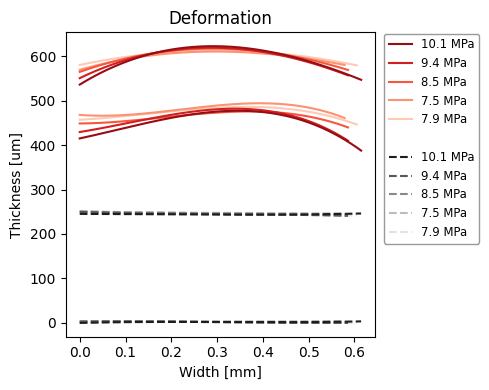

In [245]:
#Plot fitted curves of different tomographs
#--------
path = r'C:\Users\FChabot\Documents\Tomography\Compression\0p65mm_Mott_N115\1- Analysis'
figureName = '0p65mm_Bekaert_N115_Compression' #< TO DO
# filesNames = ['1mm_Bekaert_NR212_Dry_Fit',
#               '1mm_Bekaert_NR212_Wet_Fit',
#               '1mm_Bekaert_NR212_5Ncm_Fit',]
filesNames = ['Test-80_Comp_0p65mm_Mott_N115_Wet_Fit',
              'Test-81_Comp_0p65mm_Mott_N115_5Ncm_Fit',
              'Test-82_Comp_0p65mm_Mott_N115_8p5Ncm_Fit',
              'Test-83_Comp_0p65mm_Mott_N115_13Ncm_Fit',
              'Test-84_Comp_0p65mm_Mott_N115_17Ncm_Fit',]
# labels = ['Dry', 'Wet', '9.5 MPa']
labels = ['7.9 MPa','7.5 MPa','8.5 MPa','9.4 MPa','10.1 MPa']
colors = [plt.cm.Greys(np.linspace(0.2,0.9,len(filesNames))), plt.cm.Reds(np.linspace(0.2,0.9,len(filesNames)))] #To change colors, change the name of the colormaps
lineS = ['--','--','-','-']
#---------

fig, ax = plt.subplots(1,1, figsize=(5, 4))
x_list = []
y_list = []
for fileN in filesNames[:]: #Extracting data from files
    print(fileN)
    df=pd.read_csv(os.path.join(path, fileN+'.csv'), index_col='Unnamed: 0')
    i = 0
    x_l = []
    y_l = []
    for col in reversed(df.columns[:]):
        data = df[col].loc[:]
        x = np.linspace(int(data.iloc[0]), int(data.iloc[1]), int(data.iloc[1]-data.iloc[0]+1))
        y = func(x, *data.iloc[2:])
        if i == 0:
            mini = min(y)
        y = (y-mini)
        x_l += [list(x)]
        y_l += [list(y)]
        i+=1 
    x_list += [x_l]
    y_list += [y_l]
        
i=0
cl = 0
for i in range(len(x_l)): #Plotting
    j=0
    for j in range(len(x_list)):
        x = x_list[j][i]
        y = y_list[j][i]
        if i == 2:
            cl=1
        if i%2 == 1 :
            ax.plot((np.array(x)-min(x))*pixSize/1000, np.array(y)*pixSize, c=colors[cl][j], linestyle=lineS[i], label=labels[j]) #Plot PTL data
        else:
            ax.plot((np.array(x)-min(x))*pixSize/1000, np.array(y)*pixSize, c=colors[cl][j], linestyle=lineS[i]) #Plot GDL data
        if (i==2) and (j==len(x_list)-1): #Adding a space in the legend
            ax.plot((np.array(x)-min(x))*pixSize/1000, np.array(y)*pixSize, alpha=0, label=' ')
        j+=1
    i+=1
    
ax.set_title('Deformation')
ax.set_xlabel('Width [mm]')
ax.set_ylabel('Thickness [um]')
plt.legend(bbox_to_anchor=(1.01, 1.015), loc="upper left", fontsize='small', ncols=1, edgecolor='0.5', reverse=True)
fig.tight_layout()
fig.savefig(os.path.join(path, figureName + '.png'), dpi=300, transparent=True)

## Calculate and plot average thicknesses
___

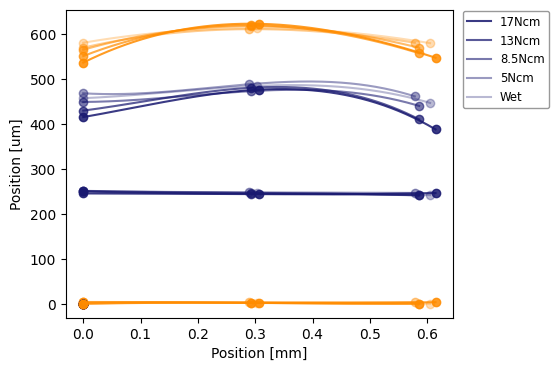

In [246]:
#Calculate thicknesses in the channel from the fitted results
#----------
path = r'C:\Users\FChabot\Documents\Tomography\Compression\0p65mm_Mott_N115\1- Analysis'
dataFileName = '0p65mm_Bekaert_N115_Compression'

fileNames = ['Test-80_Comp_0p65mm_Mott_N115_Wet_Fit',
             'Test-81_Comp_0p65mm_Mott_N115_5Ncm_Fit',
             'Test-82_Comp_0p65mm_Mott_N115_8p5Ncm_Fit',
             'Test-83_Comp_0p65mm_Mott_N115_13Ncm_Fit',
             'Test-84_Comp_0p65mm_Mott_N115_17Ncm_Fit',]

conditions = ['Wet', '5Ncm', '8.5Ncm', '13Ncm', '17Ncm'] 
colors = ['darkorange', 'midnightblue']
#----------

alpha = np.linspace(0.3, 1, len(fileNames)+1)
pixSize = 0.635 #um
colors += reversed(colors)

fig, ax = plt.subplots(1,1, figsize=(5, 4))
cond_l = []
data = []
rows = []
i = 0
for fileN in fileNames:
    df=pd.read_csv(os.path.join(path, fileN+'.csv'), index_col='Unnamed: 0')
    # data = []
    rows += ['Xpixel']
    th_l = []
    j=0
    for col in reversed(df.columns[:]):  
        x1 = np.linspace(int(df[col].iloc[0]), int(df[col].iloc[1]), int(df[col].iloc[1]-df[col].iloc[0]+1))
        y1 = func(x1, *df[col].iloc[2:])
        if j == 0:
            y1_min = min(y1)
        x1 = x1 - min(x1)
        y1 = y1 - y1_min
        
        x = [x1[0], x1[-1], x1[int(len(x1)/2)], 0, 0] #pixel position on x [top, bottom, middle] #TEst
        y = [y1[0], y1[-1], y1[int(len(y1)/2)], 0, 0] #pixel position on y [top, bottom, middle] #TEst

        if col == df.columns[-1]:
            y_t = y
            y1_t = y1
            data += [list([x[0], x[1], x[2], 0, 0])]
        else:
            th = np.array(y) - np.array(y_t) #pixel position versus previous surface [top, bottom, middle]
            th_avg = np.mean(np.array(y1) - np.array(y1_t)) #Average pixel position versus previous surface
            th_l += [list(np.append(th[:-2], [(th[0]+th[1])/2, th_avg]))]
            y_t = y
            y1_t = y1

        data += [list(y)] #append pixel position on y [top, bottom, middle] ordered as ['PTL thick.', 'Membrane thick.', 'GDL thick.']
        rows += [col]

        if j==1 :
            ax.plot(np.array(x1)*pixSize/1000, np.array(y1)*pixSize, c=colors[j], alpha=alpha[i], label=conditions[i])
        else:
            ax.plot(np.array(x1)*pixSize/1000, np.array(y1)*pixSize, c=colors[j], alpha=alpha[i])
        ax.scatter(np.array(x)*pixSize/1000, np.array(y)*pixSize, c=colors[j], alpha=alpha[i])
        j += 1

    plt.legend(bbox_to_anchor=(1.01, 1.015), loc="upper left", fontsize='small', ncols=1, edgecolor='0.5', reverse=True)
    
    data += th_l
    data += [list(np.array(th_l[1])+np.array(th_l[2]))]
    rows += ['PTL thick.', 'Membrane thick.', 'GDL thick.', 'GDL+Membrane thick.']
    
    i+=1
ax.set_xlabel('Position [mm]')
ax.set_ylabel('Position [um]')

#Creating a list of the conditions 
for c in conditions:
    for r in range(9):
        cond_l += [c]
        
#Saving data - Values are in pixels 
df_r = pd.DataFrame(data, index=rows, columns=['Top', 'Bottom', 'Middle', 'EdgeMean', 'Average'])
df_r.insert(loc=0, column='Conditions', value=cond_l)
df_r.insert(loc=0, column='Parameters', value=rows)
df_r.to_csv(os.path.join(path, dataFileName+'-thick.csv'), index=False)

### --- Hydration : Membrane and GDL ---

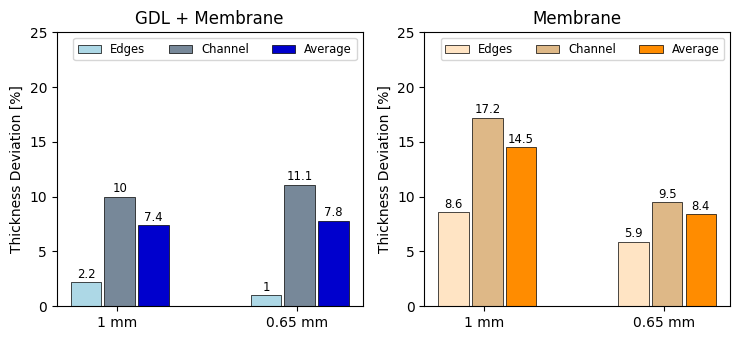

In [250]:
#Plotting the thickness deviation of Membane and Membrane + GDL with hydration
#---------
path = r'C:\Users\FChabot\Documents\Tomography\Compression'
folders = ['0p65mm_Mott_N115', '0p65mm_Bekaert_N115']
figureName = 'Bekaert_vs_Mott'
outputPath = os.path.join(path, 'Hydration_'+figureName+'.png')

lab_names = ['1 mm', '0.65 mm']
colors1 = ['bisque', 'burlywood', 'darkorange']
colors2 = ['lightblue', 'lightslategrey', 'mediumblue']
width = 0.17  # the width of the bars
spacing = 0.1 # the spacing of the bars
#---------

subfolder = '1- Analysis'
conditions = ['Dry', 'Wet']
thicknesses = ['GDL thick.', 'Membrane thick.', 'PTL thick.', 'GDL+Membrane thick.']

channelDev1_l, edgeDev1_l, meanDev1_l = [], [], []
channelDev2_l, edgeDev2_l, meanDev2_l = [], [], []

fig, ax = plt.subplots(1, 2, figsize=(7.5,3.5)) 
r=0
for f in folders:
    filePath = os.path.join(path, f, subfolder, f+'-thick.csv')
    df = pd.read_csv(filePath)
 
    #Calculate the thickness deviation of GDL + Membrane
    df2 = df[df['Parameters']==thicknesses[3]]
    meanDev1 = (float(df2[df2['Conditions']==conditions[1]]['Average'].iloc[0]) - float(df2[df2['Conditions']==conditions[0]]['Average'].iloc[0]))/float(df2[df2['Conditions']==conditions[0]]['Average'].iloc[0]) 
    channelDev1 = (float(df2[df2['Conditions']==conditions[1]]['Middle'].iloc[0]) - float(df2[df2['Conditions']==conditions[0]]['Middle'].iloc[0]))/float(df2[df2['Conditions']==conditions[0]]['Middle'].iloc[0])
    edgeDev1 = (float(df2[df2['Conditions']==conditions[1]]['EdgeMean'].iloc[0]) - float(df2[df2['Conditions']==conditions[0]]['EdgeMean'].iloc[0]))/float(df2[df2['Conditions']==conditions[0]]['EdgeMean'].iloc[0]) 

    meanDev1_l += [round(meanDev1*100,1)]
    channelDev1_l += [round(channelDev1*100,1)]
    edgeDev1_l += [round(edgeDev1*100,1)]

    #Calculate the thickness deviation of Membrane alone
    df2 = df[df['Parameters']==thicknesses[1]]
    meanDev2 = (float(df2[df2['Conditions']==conditions[1]]['Average'].iloc[0]) - float(df2[df2['Conditions']==conditions[0]]['Average'].iloc[0]))/float(df2[df2['Conditions']==conditions[0]]['Average'].iloc[0]) 
    channelDev2 = (float(df2[df2['Conditions']==conditions[1]]['Middle'].iloc[0]) - float(df2[df2['Conditions']==conditions[0]]['Middle'].iloc[0]))/float(df2[df2['Conditions']==conditions[0]]['Middle'].iloc[0])
    edgeDev2 = (float(df2[df2['Conditions']==conditions[1]]['EdgeMean'].iloc[0]) - float(df2[df2['Conditions']==conditions[0]]['EdgeMean'].iloc[0]))/float(df2[df2['Conditions']==conditions[0]]['EdgeMean'].iloc[0]) 

    meanDev2_l += [round(meanDev2*100,1)]
    channelDev2_l += [round(channelDev2*100,1)]
    edgeDev2_l += [round(edgeDev2*100,1)]

#Plotting GDL + Membrane ---
deviation1 = {'Edges' : edgeDev1_l,
              'Channel': channelDev1_l,
              'Average': meanDev1_l,}
x = np.arange(len(lab_names))  # the label locations
multiplier = 0
i = 0
for attribute, measurement in deviation1.items():
    offset = width * multiplier
    rects = ax[0].bar(x + offset, measurement, width, label=attribute, color=colors2[i], edgecolor='k', linewidth=0.5)
    ax[0].bar_label(rects, padding=1, fontsize='small')
    multiplier += 1 + spacing
    i += 1
ax[0].set_ylabel('Thickness Deviation [%]')
ax[0].set_title('GDL + Membrane')
ax[0].set_xticks(x + width, lab_names)
ax[0].legend(loc='upper right', ncols=3, fontsize='small')
ax[0].set_ylim(0, 25)

#Plotting Membrane alone ---
deviation2 = {'Edges' : edgeDev2_l,
              'Channel': channelDev2_l,
              'Average': meanDev2_l,}
x = np.arange(len(lab_names))  # the label locations
multiplier = 0
i = 0
for attribute, measurement in deviation2.items():
    offset = width * multiplier
    rects = ax[1].bar(x + offset, measurement, width, label=attribute, color=colors1[i], edgecolor='k', linewidth=0.5)
    ax[1].bar_label(rects, padding=1, fontsize='small')
    multiplier += 1 + spacing
    i += 1
ax[1].set_ylabel('Thickness Deviation [%]')
ax[1].set_title('Membrane')
ax[1].set_xticks(x + width, lab_names)
ax[1].legend(loc='upper right', ncols=3, fontsize='small')
ax[1].set_ylim(0, 25)

fig.tight_layout()
fig.savefig(outputPath, dpi=300)

### --- GDL+Membrane and PTL ---

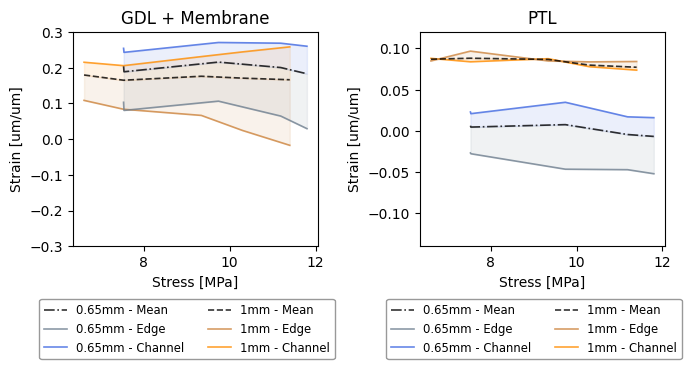

In [251]:
#--Meant to plot PTL thickness and Membrane+GDL thickness
#Needs to calibrate compression before plotting anything
#Plot as a fonction of estimated pressure or normalized ?

path = r'C:\Users\FChabot\Documents\Tomography\Compression'
folders = ['0p65mm_Mott_N115', '0p65mm_Bekaert_N115']
figureName = 'Mott_vs_Beakaert'
lab_names = ['1mm', '0.65mm']
colors_l = ['darkorange', 'peru', 'royalblue', 'slategrey']
lines = ['--', '-.']

outputPath = os.path.join(path, 'Compression_'+figureName+'_strain'+'.png')
subfolder = '1- Analysis'
conditions = ['Wet', '5Ncm', '8.5Ncm', '13Ncm', '17Ncm'] 
thicknesses = ['GDL thick.', 'Membrane thick.', 'PTL thick.', 'GDL+Membrane thick.']
GDL_N115_thick, GDL_NR212_thick, Sintered_thick, Fiber_thick, = 377, 301, 246, 225,  #um
pressure_1 = [6.61,7.53,9.34,10.3,11.4] #in MPa
pressure_2 = [7.53,7.54,9.74,11.19,11.8] #in MPa
zero_thick = [GDL_NR212_thick, Fiber_thick]
# conditions = ['Dry', 'Wet', '5Ncm', '8p5Ncm', '13Ncm', '17Ncm']

x = pressure_1
fig, ax = plt.subplots(1, 2, figsize=(7,4)) 
r=0
for f in folders:
    colors = colors_l[2*r:2*r+2]
    filePath = os.path.join(path, f, subfolder, f+'-thick.csv')
    df = pd.read_csv(filePath)
    
    df2 = pd.DataFrame()
    df_t = pd.DataFrame()
    for c in conditions:
        df_t = df[df['Conditions']==c]
        df2 = pd.concat([df2, df_t])
    
    #Plot GDL + Membrane
    mean = df2[df2['Parameters']==thicknesses[3]]['Average']*0.635
    channel = df2[df2['Parameters']==thicknesses[3]]['Middle']*0.635
    edge = df2[df2['Parameters']==thicknesses[3]]['EdgeMean']*0.635
    
    ax[0].fill_between(x, (mean - zero_thick[0])/zero_thick[0], (channel - zero_thick[0])/zero_thick[0], color=colors[0], alpha=0.1)
    ax[0].plot(x, (channel - zero_thick[0])/zero_thick[0], color=colors[0], alpha=0.8, label=lab_names[r]+' - '+'Channel', linewidth=1.2)
    ax[0].fill_between(x, (mean - zero_thick[0])/zero_thick[0], (edge - zero_thick[0])/zero_thick[0], color=colors[1], alpha=0.1)
    ax[0].plot(x, (edge - zero_thick[0])/zero_thick[0], color=colors[1], alpha=0.8, label=lab_names[r]+' - '+'Edge', linewidth=1.2)
    ax[0].plot(x, (mean - zero_thick[0])/zero_thick[0], color='k', linestyle=lines[r], label=lab_names[r]+' - '+'Mean', alpha=0.8, linewidth=1.2)
    # ax[0].set_xticks(x, conditions, size = '8')

    #Plot PTL
    mean = df2[df2['Parameters']==thicknesses[2]]['Average']*0.635
    channel = df2[df2['Parameters']==thicknesses[2]]['Middle']*0.635
    edge = df2[df2['Parameters']==thicknesses[2]]['EdgeMean']*0.635
    
    ax[1].plot(x, (channel - zero_thick[1])/zero_thick[1], color=colors[0], alpha=0.8, label=lab_names[r]+' - '+'Channel', linewidth=1.2)
    ax[1].plot(x, (edge - zero_thick[1])/zero_thick[1], color=colors[1], alpha=0.8, label=lab_names[r]+' - '+'Edge', linewidth=1.2)
    ax[1].plot(x, (mean - zero_thick[1])/zero_thick[1], color='k', linestyle=lines[r], label=lab_names[r]+' - '+'Mean', alpha=0.8, linewidth=1.2)
    ax[1].fill_between(x, (mean - zero_thick[1])/zero_thick[1], (channel - zero_thick[1])/zero_thick[1], color=colors[0], alpha=0.1)    
    ax[1].fill_between(x, (mean - zero_thick[1])/zero_thick[1], (edge - zero_thick[1])/zero_thick[1], color=colors[1], alpha=0.1)
    # ax[1].set_xticks(x, conditions, size = '8')
    x = pressure_2
    # conditions = ['Wet', '5Ncm', '8.5Ncm', '13Ncm', '17Ncm']  #To remove
    r+=1
# ax[0].set_xlim(8, 12)
ax[0].set_ylabel('Strain [um/um]')
ax[0].set_xlabel('Stress [MPa]')
ax[0].set_title('GDL + Membrane')
ax[0].legend(bbox_to_anchor=(-0.16, -0.22), loc="upper left", fontsize='small', ncols=2, edgecolor='0.5', reverse=True)
ax[0].set_ylim(-0.3, 0.3)

# ax[1].set_xlim(-0.06, 0.06)
ax[1].set_ylabel('Strain [um/um]')
ax[1].set_xlabel('Stress [MPa]')
ax[1].set_title('PTL')
ax[1].legend(bbox_to_anchor=(-0.16, -0.22), loc="upper left", fontsize='small', ncols=2, edgecolor='0.5', reverse=True)
ax[1].set_ylim(-0.14, 0.12)

fig.tight_layout()
fig.savefig(outputPath, dpi=300)

### --- All thicknesses ---

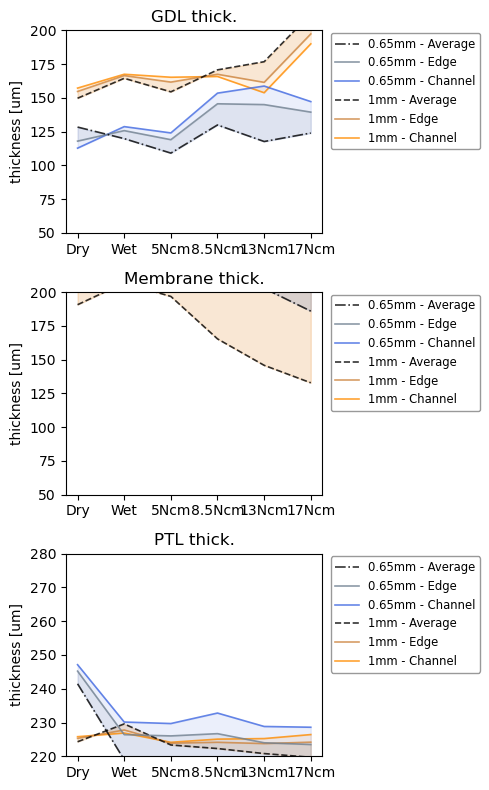

In [488]:
#Needs to calibrate compression before plotting anything
#Plot as a fonction of estimated pressure or normalized ? 

path = r'D:\Compression -\24-11-10 - CompressionPEMWE'
folders = ['1mm_Bekaert_N115', '0p65mm_Bekaert_N115']
lab_names = ['1mm', '0.65mm']
colors_l = ['darkorange', 'peru', 'royalblue', 'slategrey']
lines = ['--', '-.']

subfolder = '1- Analysis'
conditions = ['Dry', 'Wet', '5Ncm', '8.5Ncm', '13Ncm', '17Ncm']
thicknesses = ['GDL thick.', 'Membrane thick.', 'PTL thick.']
# conditions = ['Dry', 'Wet', '5Ncm', '8p5Ncm', '13Ncm', '17Ncm']

fig, ax = plt.subplots(3, 1, figsize=(5,8)) 
r=0
for f in folders:
    colors = colors_l[2*r:2*r+2]
    filePath = os.path.join(path, f, subfolder, f+'-thick.csv')
    df = pd.read_csv(filePath)
    
    df2 = pd.DataFrame()
    df_t = pd.DataFrame()
    for c in conditions:
        df_t = df[df['Conditions']==c]
        df2 = pd.concat([df2, df_t])
    i=0
    for t in thicknesses:
        mean = df2[df2['Parameters']==t]['EdgeMean']  
        channel = df2[df2['Parameters']==t]['Middle']  
        edge = df2[df2['Parameters']==t]['Average']
        x = np.linspace(0, len(edge)-1, len(edge))
        
        ax[i].fill_between(x, mean*0.635, channel*0.635, color=colors[0], alpha=0.1)
        ax[i].plot(x, channel*0.635, color=colors[0], alpha=0.8, label=lab_names[r]+' - '+'Channel', linewidth=1.2)
        ax[i].fill_between(x, mean*0.635, edge*0.635, color=colors[1], alpha=0.1)
        ax[i].plot(x, edge*0.635, color=colors[1], alpha=0.8, label=lab_names[r]+' - '+'Edge', linewidth=1.2)
        ax[i].plot(x, mean*0.635, color='k', linestyle=lines[r], label=lab_names[r]+' - '+'Average', alpha=0.8, linewidth=1.2)
        ax[i].set_xticks(x, conditions)
        ax[i].set_ylabel('thickness [um]')
        ax[i].set_title(t)
        ax[i].legend(bbox_to_anchor=(1.01, 1.015), loc="upper left", fontsize='small', ncols=1, edgecolor='0.5', reverse=True)
        i+=1
    r+=1
    ax[0].set_ylim(50, 200)
    ax[1].set_ylim(50, 200)
    ax[2].set_ylim(220, 280)
    
    fig.tight_layout()